In [9]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('autoencoder_fastf1.keras')  # Replace with the correct path to your saved model

# Print the model summary to confirm it loaded correctly
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 25)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10, 64)         │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 10, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 25)         │         1,625 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 210,701 (823.05 KB)

 Trainable params: 70,233 (274.35 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 140,468 (548.71 KB)

In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np
file_path = "/AllTelemetryData/2022/all_drivers_AustralianGrandPrix_2022.csv"
X_test = pd.read_csv(file_path)
# X_test = X_test[X_test["DriverNumber"]=="5"]


In [11]:
def convert_time_to_seconds(time_str):
    """
    Converts a timestamp string (e.g., '00:00.557') to seconds as float.
    Args:
        time_str (str): Time string in 'HH:MM:SS.sss' or 'MM:SS.sss' format.
    Returns:
        float: Time in seconds.
    """
    try:
        if pd.isnull(time_str) or time_str.strip() == '':
            return 0.0
        parts = time_str.split(':')
        if len(parts) == 3:  # HH:MM:SS.sss
            h, m, s = map(float, parts)
            return h * 3600 + m * 60 + s
        elif len(parts) == 2:  # MM:SS.sss
            m, s = map(float, parts)
            return m * 60 + s
        else:
            return float(time_str)  # Directly convert if already numeric
    except ValueError:
        return 0.0  # Handle invalid format gracefully

def check_columns(df, columns):
    """
    Args:
        df (DataFrame): Input dataset.
        columns (list): List of columns to check.
    Returns:
        list: Columns present in the dataset.
    """
    return [col for col in columns if col in df.columns]

def map_grand_prix(df):
    """
    Maps Grand Prix events to unique numeric identifiers and removes the original 'Event' column.
    
    Args:
        df (DataFrame): Input DataFrame containing the 'Event' column.
    
    Returns:
        DataFrame: Updated DataFrame with the new column 'Event_mapped'.
        dict: Mapping of events to their numeric identifiers.
    """
    # Create a sorted list of unique events
    grand_prix_list = sorted(df['Event'].unique())  # Ensure consistent mapping order
    event_mapping = {event: idx + 1 for idx, event in enumerate(grand_prix_list)}  # Map to integers

    # Add the mapped column
    df['Event_mapped'] = df['Event'].map(event_mapping).fillna(0).astype(int)
    
    # Drop the original 'Event' column
    df = df.drop(columns=['Event'], errors='ignore')
    
    return df, event_mapping

In [12]:
def normalize_data(df):
    """
    Features are handled as follows:
    1. Numerical features: Standardized using `StandardScaler` to ensure all values are on the same scale.
       - Examples: Lap times, sector times, environmental variables, telemetry data, etc.

    2. Categorical features: One-hot encoded using `OneHotEncoder` to create binary vector representations.
       - Examples: Tire compound, track status.

    3. Pit stop time: Calculated as the difference between `PitOutTime` and `PitInTime`, then normalized.

    4. Non-normalized features: Retained as-is since they are either already in the correct format or represent discrete values.
       - Examples: Driver number, stint number, lap number.

    5. Dropped features: Irrelevant or redundant features removed based on domain knowledge (for this kind of training).
       - Examples: Driver name, team name, inaccurate or redundant telemetry features.
    
    Args:
        df (DataFrame): Input dataset containing raw telemetry and race data.
    
    Returns:
        np.array: Preprocessed dataset, combining standardized numerical features, 
                  one-hot encoded categorical features, and unprocessed features.
    """
    
    # List of time columns to convert
    time_columns = [
        'Time', 'LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
        'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
        'PitOutTime', 'PitInTime'
    ]

    # Convert all time columns to seconds
    for col in time_columns:
        if col in df.columns:
            df[col] = df[col].apply(convert_time_to_seconds)

    # Columns to normalize
    numerical_cols = [
        'Time', 'LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
        'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
        'Speedl1', 'Speedl2', 'SpeedFL', 'Speed', 'AirTemp', 'Humidity',
        'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed',
        'DistanceToDriverAhead', 'RPM', 'nGear', 'Throttle', 'Brake',
        'DRS', 'X', 'Y', 'Z', 'Distance'
    ]

    # THIS IS TEMPORARY: WE NEED TO MANAGE BETTER THE "OBJECT" TYPE

    # Handle `Compound` with OneHotEncoder
    if 'Compound' in df.columns:
        one_hot = pd.get_dummies(df['Compound'], prefix='Compound')
        df = pd.concat([df, one_hot], axis=1).drop(columns=['Compound'])

    # Map Event column to numeric identifiers
    if 'Event' in df.columns:
        df, event_mapping = map_grand_prix(df)
        # print("Mapped Grand Prix events:", event_mapping)

    # Columns to one-hot encode
    categorical_cols = ['TrackStatus']

    # Columns to leave unprocessed
    non_normalized_cols = ['DriverNumber', 'Stint', 'LapNumber', 'Position', 'IsPersonalBest', 'Year', 'Event']

    # Columns to drop (irrelevant or redundant)
    drop_cols = [
        'Driver', 'SpeedST', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime', 'LapStartDate',
        'Deleted', 'DeletedReason', 'FastF1Generated', 'isAccurate', 'Status', 'Date', 'SessionTime',
        'RelativeDistance', 'Source', 'DriverAhead', 
    ]

    # Drop irrelevant columns if they exist in the dataset
    df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

    # Check existing columns in the dataset
    numerical_cols = [col for col in numerical_cols if col in df.columns]
    categorical_cols = [col for col in categorical_cols if col in df.columns]
    non_normalized_cols = [col for col in non_normalized_cols if col in df.columns]

    # Handle pit stop time as a derived feature
    if 'PitOutTime' in df.columns and 'PitInTime' in df.columns:
        df['PitStopTime'] = (df['PitOutTime'] - df['PitInTime']).fillna(0).astype(float)
        df = df.drop(columns=['PitOutTime', 'PitInTime'], errors='ignore')
        numerical_cols.append('PitStopTime')

    # Preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),  # Standardize numerical features
            ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_cols),  # Encode categorical features
        ],
        remainder='passthrough'  # Retain non-normalized features as-is
    )

    print("\n", df.dtypes, "\n")

    # Ensure all boolean columns are converted to int (otherwise it cause a problem)
    df = df.apply(lambda col: col.map({True: 1, False: 0}) if col.dtypes == 'bool' else col)

    # Apply transformations
    processed_data = preprocessor.fit_transform(df)
    return processed_data


In [13]:
def sliding_window_generator(data, sequence_length, batch_size):
    """
    Generates sliding windows dynamically for training and validation
    Args:
        data (array): Input data.
        sequence_length (int): Number of timesteps in each sequence.
        batch_size (int): Number of sequences per batch.
    Yields:
        tuple: Batch of sequences (X, X) for autoencoder training.
    """
    num_samples = len(data) - sequence_length + 1
    while True:
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            batch_data = np.array([data[i:i+sequence_length] for i in range(start_idx, end_idx)])
            # When the yield statement is executed, the generator state is frozen and the value of the expression_list 
            # is returned to the next() call
            yield batch_data, batch_data    
            # the input and the label (X and y) are identical, typical for an autoencoder, since the model has to reconstruct the input data


In [14]:
data_preprocessed = normalize_data(X_test)
data_preprocessed_windows = sliding_window_generator(data_preprocessed,10,32)


 DriverNumber         int64
LapNumber            int64
AirTemp            float64
Humidity           float64
Pressure           float64
Rainfall              bool
TrackTemp          float64
WindDirection        int64
WindSpeed          float64
Time               float64
RPM                  int64
Speed                int64
nGear                int64
Throttle             int64
Brake                 bool
DRS                  int64
Distance           float64
X                  float64
Y                  float64
Z                  float64
Year                 int64
Compound_HARD         bool
Compound_MEDIUM       bool
Compound_SOFT         bool
Event_mapped         int32
dtype: object 



In [ ]:

loss = model.evaluate(data_preprocessed_windows, data_preprocessed_windows)  # Autoencoders typically use the same input as the target
print(f"Test Loss: {loss:.4f}")

ValueError: When providing `x` as a PyDataset, `y` should not be passed. Instead, the targets should be included as part of the PyDataset.

In [16]:
sequence_length = 10
batch_size = 32
steps_per_epoch = (len(X_test) - sequence_length + 1) // batch_size

# Calcola l'errore di ricostruzione per ciascuna sequenza
reconstruction_error = []
for _ in range(steps_per_epoch):
    batch_data, _ = next(data_preprocessed_windows)  # Ottieni il prossimo batch
    reconstructed_data = model.predict(batch_data)  # Predici la ricostruzione
    # Calcola l'errore di ricostruzione per il batch
    batch_reconstruction_error = np.mean((batch_data - reconstructed_data)**2, axis=(1, 2))  # MSE su ogni sequenza
    reconstruction_error.extend(batch_reconstruction_error)

# Calcola l'errore di ricostruzione complessivo
reconstruction_error = np.array(reconstruction_error)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━

In [18]:
reconstruction_error.mean()

28.44210888844719

In [31]:
# Definire una soglia per l'errore di ricostruzione
threshold = np.percentile(reconstruction_error, 99)  # Soglia come il 95° percentile dell'errore

# Identificare le anomalie (dove l'errore di ricostruzione è maggiore della soglia)
anomalies = reconstruction_error > threshold

# Visualizzare le anomalie
print("Anomalous sequences (True if anomaly detected):")
print(len(anomalies),len(anomalies[anomalies==True]),len(reconstruction_error))

Anomalous sequences (True if anomaly detected):
728320 7284 728320


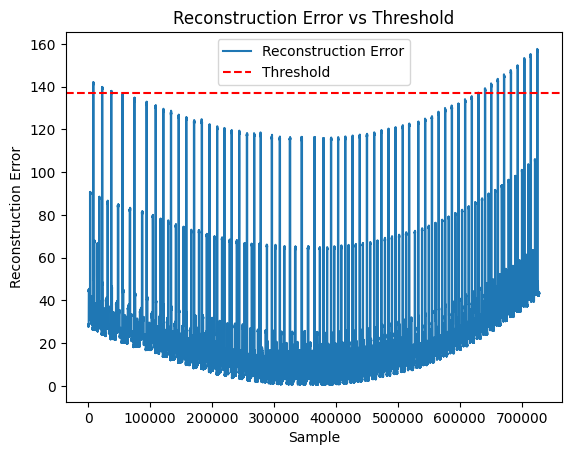

In [28]:
import matplotlib.pyplot as plt 

plt.plot(reconstruction_error, label="Reconstruction Error")
plt.axhline(y=threshold, color='r', linestyle='--', label="Threshold")
plt.title("Reconstruction Error vs Threshold")
plt.xlabel("Sample")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.show()

In [35]:
filtered = X_test[:len(X_test)-19]
filtered = filtered[anomalies]

In [39]:
set(list(filtered["DriverNumber"]))

{31, 77}